# Tarea 2 Panel y Pseudo-experimentos - Pauta

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import linearmodels.panel as lmp
import pytwoway as tw
import bipartitepandas as bpd
import seaborn as sns
from linearmodels.iv import IV2SLS

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

print("Librerías cargadas.");

Librerías cargadas.


### Preguntas:

### 1. Crear un set de datos de frecuencia mensual que permita estudiar el efecto de las cuarentenas dinamicas (paso a paso) sobre la calidad del aire en las comunas que poseen estaciones de medicion durante 2021. Queda a discrecion como agregar y generar el set de datos final para estimacion.

In [23]:
df = pd.read_csv("..\data\paso_a_paso.csv");
aux = df[[col for col in df.columns if '2021' in col]];
aux.columns = pd.to_datetime(aux.columns);
df_mensual = aux.transpose().resample('M').agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]).transpose();
df_mensual.columns = [f"{col.month:02d}" for col in df_mensual.columns];
df21 = pd.concat([df[['codigo_region', 'region_residencia', 'codigo_comuna', 'comuna_residencia', 'zona']], df_mensual], axis=1);
df21_melted = df21.melt(id_vars=['codigo_region', 'region_residencia', 'codigo_comuna', 'comuna_residencia', 'zona'], 
                        var_name='Mes', value_name='Paso');
df21_melted['Mes'] = df21_melted['Mes'].astype(str);

mp = pd.read_csv("..\data\MP2.5-2021_std.csv");
mp.drop(columns=["Rancagua_II", "Valdivia_II", "Coyhaique_II", "Talca_La_Florida", "Alerce"], inplace=True);
nombres = {mp.columns[i]: new_name for i, new_name in enumerate([
    'Hora', 'Arica', 'Alto Hospicio', 'Antofagasta', 'Copiapó', 'Huasco', 'Coquimbo', 'La Serena', 'Concón', 'Valparaíso',
    'Viña del Mar', 'Independencia', 'La Florida', 'Las Condes', 'Santiago', 'Pudahuel', 'El Bosque', 'Cerro Navia',
    'Puente Alto', 'Quilicura', 'Rancagua', 'Rengo', 'San Fernando', 'Curicó', 'Maule', 'Talca', 'Linares', 'Nielol',
    'Las Encinas', 'Padre Las Casas', 'Valdivia', 'Osorno', 'Mirasol', 'Coyhaique', 'Punta Arenas', 'La Unión', 'Vialidad', 'Talagante'])}
mp.rename(columns=nombres, inplace=True);
mp['Hora'] = pd.to_datetime(mp['Hora']);
mp['Fecha'] = mp['Hora'].dt.date;
aux = mp.groupby('Fecha').mean();
aux2 = aux.T;
aux2.columns = pd.to_datetime(aux2.columns);
mp = aux2.groupby(aux2.columns.to_period('M'), axis=1).mean();
mp = mp.drop(mp.index[0]);
mp = mp.dropna();
mp.reset_index(inplace=True);
mp.rename(columns={'index': 'Comuna'}, inplace=True);
mp_melted = mp.melt(id_vars=['Comuna'], var_name='Mes', value_name='MP');
mp_melted['Mes'] = mp_melted['Mes'].astype(str).str.slice(5, 7);

mp_melted['Comuna'] = mp_melted['Comuna'].astype(str);
df21_melted.rename(columns={'comuna_residencia': 'Comuna'}, inplace=True);

com = set(df21_melted['Comuna']).intersection(set(mp_melted['Comuna']));
mes = set(df21_melted['Mes']).intersection(set(mp_melted['Mes']));

df21_aux = df21_melted[df21_melted['Comuna'].isin(com) & df21_melted['Mes'].isin(mes)];
mp_aux = mp_melted[mp_melted['Comuna'].isin(com) & mp_melted['Mes'].isin(mes)];
df = pd.merge(df21_aux, mp_aux, on=['Comuna', 'Mes'], suffixes=('_df21', '_mp'));

nac21 = pd.read_csv(r"..\data\Nac.csv");
date_cols = [col for col in nac21.columns if col.startswith('2021')]
nac21_2021 = nac21[date_cols]
nac21_2021 = nac21_2021.apply(pd.to_numeric, errors='coerce')
dates = pd.to_datetime(date_cols, format='%Y-%m-%d')
monthly_data = nac21_2021.groupby(dates.month, axis=1).mean()
monthly_data.columns = monthly_data.columns.astype(str)
non_date_cols = nac21[['Region', 'Codigo region', 'Comuna', 'Codigo comuna']]
nac21 = pd.concat([non_date_cols, monthly_data], axis=1)
nac21_melted = nac21.melt(id_vars=['Region', 'Codigo region', 'Comuna', 'Codigo comuna'], var_name='Mes', value_name='Nacimientos')
nac21_melted.rename(columns={'Comuna': 'Comuna'}, inplace=True)
nac21_melted['Mes'] = nac21_melted['Mes'].astype(int)
df["Mes"] = df["Mes"].astype(int);
df['Comuna'] = df['Comuna'].astype(str);
nac21_melted['Comuna'] = nac21_melted['Comuna'].astype(str);
df = pd.merge(df, nac21_melted[['Comuna', 'Mes', 'Nacimientos', 'Codigo comuna']], on=['Comuna', 'Mes'], suffixes=('_df21', '_nac21'));

def21 = pd.read_csv("..\data\Def.csv");
date_cols = [col for col in def21.columns if col.startswith('2021')]
def21_2021 = def21[date_cols]
def21_2021 = def21_2021.apply(pd.to_numeric, errors='coerce')
dates = pd.to_datetime(date_cols, format='%Y-%m-%d')
monthly_data = def21_2021.groupby(dates.month, axis=1).mean()
monthly_data.columns = monthly_data.columns.astype(str)
non_date_cols = def21[['Region', 'Codigo region', 'Comuna', 'Codigo comuna']]
def21 = pd.concat([non_date_cols, monthly_data], axis=1)
def21_melted = def21.melt(id_vars=['Region', 'Codigo region', 'Comuna', 'Codigo comuna'], var_name='Mes', value_name='Defunciones')
def21_melted.rename(columns={'Comuna': 'Comuna'}, inplace=True)
def21_melted['Mes'] = def21_melted['Mes'].astype(int)
df["Mes"] = df["Mes"].astype(int);
df['Comuna'] = df['Comuna'].astype(str);
def21_melted['Comuna'] = def21_melted['Comuna'].astype(str);
df = pd.merge(df, def21_melted[['Comuna', 'Mes', 'Defunciones', 'Codigo comuna']], on=['Comuna', 'Mes'], suffixes=('_df21', '_def21'));

week = pd.read_csv("..\data\ISCI_weeks.csv");
week['fecha_termino'] = pd.to_datetime(week['fecha_termino']);
week_2021 = week[week['fecha_termino'].dt.year == 2021];
week_2021['Mes'] = week_2021['fecha_termino'].dt.month;
weekly_avg = week_2021.groupby(['nom_comuna', 'comuna', 'Mes'])['var_salidas'].mean().reset_index();
week = weekly_avg[['nom_comuna', 'comuna', 'Mes', 'var_salidas']];
week.rename(columns={'var_salidas': 'SalidasSemana'}, inplace=True);

week['Mes'] = week['Mes'].astype(int);
week['comuna'] = week['comuna'].astype(int);
df = pd.merge(df, week[['comuna', 'Mes', 'SalidasSemana']], left_on=['codigo_comuna', 'Mes'], right_on=['comuna', 'Mes'], how='left');
#df.drop(columns=['comuna'], inplace=True);
df = df.drop(columns=['Codigo comuna_df21', 'Codigo comuna_def21', 'comuna']);

cont = pd.read_csv("..\data\ContactosPorComuna.csv");
date_cols = [col for col in cont.columns if '-' in col];
cont_melted = cont.melt(id_vars=['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Poblacion'], 
                        value_vars=date_cols, var_name='fecha_termino', value_name='var_salidas');
cont_melted['fecha_termino'] = pd.to_datetime(cont_melted['fecha_termino'], errors='coerce');
cont_melted = cont_melted.dropna(subset=['fecha_termino']);
cont_melted['var_salidas'] = pd.to_numeric(cont_melted['var_salidas'], errors='coerce');
cont_melted = cont_melted.dropna(subset=['var_salidas']);
cont_melted['Mes'] = cont_melted['fecha_termino'].dt.month;
monthly_avg = cont_melted.groupby(['Region', 'Codigo region', 'Comuna', 'Codigo comuna', 'Mes'])['var_salidas'].mean().reset_index();

cont = monthly_avg[['Codigo comuna', 'Mes', 'var_salidas']];
cont.rename(columns={'var_salidas': 'ContactosEstrechos'}, inplace=True);
cont['Mes'] = cont['Mes'].astype(int);
cont["Codigo comuna"] = cont["Codigo comuna"].astype(int);
df = pd.merge(df, cont, left_on=['codigo_comuna', 'Mes'], right_on=['Codigo comuna', 'Mes'], how='left');

df["Verano"] = df["Mes"].apply(lambda x: 1 if x in [1, 2, 3] else 0);
df["Otoño"] = df["Mes"].apply(lambda x: 1 if x in [4, 5, 6] else 0);
df["Invierno"] = df["Mes"].apply(lambda x: 1 if x in [7, 8, 9] else 0);
df["Primavera"] = df["Mes"].apply(lambda x: 1 if x in [10, 11, 12] else 0);

df["Etapa1_2"] = df["Paso"].apply(lambda x: 1 if x <= 2  else 0);
df["Etapa3_4"] = df["Paso"].apply(lambda x: 1 if x >= 3 else 0);

df.set_index(['Comuna', 'Mes'], inplace=True);
df.sort_index(level=['Comuna', 'Mes'], inplace=True);
df = df[df['zona'] != 'Rural'];
df.drop(columns=['zona', 'region_residencia', 'Codigo comuna'], inplace=True);
df.head(15)

codigo_region  codigo_comuna  Paso         MP  Nacimientos  \
Comuna      Mes                                                               
Antofagasta 1                2           2101     1   5.875397    15.520000   
            2                2           2101     1   6.840503    14.160000   
            3                2           2101     2   7.370589    16.230769   
            4                2           2101     1   9.726389    15.269231   
            5                2           2101     2  14.531036    15.826087   
            6                2           2101     3  13.708152    15.708333   
            7                2           2101     3     17.025    14.037037   
            8                2           2101     4  13.604839    15.720000   
            9                2           2101     4  10.397361    15.833333   
            10               2           2101     4  11.670699    14.392857   
            11               2           2101     4   9.452083    17.080000   
            12               2           2101     4   6.995104    13.137931   
Arica       1               15          15101     2  10.193726     8.880000   
            2               15          15101     1  12.417336     8.360000   
            3               15          15101     2  13.250628     9.576923   

                 Defunciones  SalidasSemana  ContactosEstrechos  Verano  \
Comuna      Mes                                                           
Antofagasta 1       8.000000       0.823707            2.553807       1   
            2       7.607143       0.808953            1.416257       1   
            3       7.451613       0.870020            1.372256       1   
            4       6.833333       0.817688            1.306003       0   
            5       6.709677       0.897977            1.643399       0   
            6       7.433333       0.887465            1.737572       0   
            7       7.967742       0.901401            1.961842       0   
            8       7.451613       0.912579            1.998472       0   
            9       6.266667       0.910950            2.634658       0   
            10      5.516129       0.909338            4.152201       0   
            11      5.900000       0.910293            4.033026       0   
            12      7.096774       0.936629            4.133493       0   
Arica       1       4.645161       0.922646            3.248714       1   
            2       5.678571       0.855577            1.822036       1   
            3       5.935484       0.941723            1.555125       1   

                 Otoño  Invierno  Primavera  Etapa1_2  Etapa3_4  
Comuna      Mes                                                  
Antofagasta 1        0         0          0         1         0  
            2        0         0          0         1         0  
            3        0         0          0         1         0  
            4        1         0          0         1         0  
            5        1         0          0         1         0  
            6        1         0          0         0         1  
            7        0         1          0         0         1  
            8        0         1          0         0         1  
            9        0         1          0         0         1  
            10       0         0          1         0         1  
            11       0         0          1         0         1  
            12       0         0          1         0         1  
Arica       1        0         0          0         1         0  
            2        0         0          0         1         0  
            3        0         0          0         1         0

### 2. Ejecute un modelo Pooled OLS para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado.

In [24]:
y = df['MP'];
X = df[['ContactosEstrechos', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño']];
X = sm.add_constant(X);
model = lmp.PanelOLS(y, X);
mco = model.fit();
print(mco)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     MP   R-squared:                        0.3723
Estimator:                   PanelOLS   R-squared (Between):              0.1320
No. Observations:                 348   R-squared (Within):               0.4402
Date:                Thu, Apr 03 2025   R-squared (Overall):              0.3723
Time:                        09:46:10   Log-likelihood                   -1400.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      40.564
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(5,342)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             40.564
                            

### 3. Ejecute un modelo efectos fijos para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado.

In [25]:
y = df['MP'];
X = df[['ContactosEstrechos', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño']];
X = sm.add_constant(X);
model = lmp.PanelOLS(y,X, entity_effects=True);
fe = model.fit(cov_type="robust");
print(fe)

                          PanelOLS Estimation Summary                           
Dep. Variable:                     MP   R-squared:                        0.4636
Estimator:                   PanelOLS   R-squared (Between):             -0.7668
No. Observations:                 348   R-squared (Within):               0.4636
Date:                Thu, Apr 03 2025   R-squared (Overall):              0.1924
Time:                        09:46:10   Log-likelihood                   -1329.4
Cov. Estimator:                Robust                                           
                                        F-statistic:                      54.277
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(5,314)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             59.256
                            

### 4. Ejecute un modelo de efectos aleatorios para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. 

In [26]:
y = df['MP'];
X = df[['ContactosEstrechos', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño']];
X = sm.add_constant(X);
model = lmp.RandomEffects(y,X);
re = model.fit(cov_type="robust")
print(re)

                        RandomEffects Estimation Summary                        
Dep. Variable:                     MP   R-squared:                        0.4312
Estimator:              RandomEffects   R-squared (Between):              0.0236
No. Observations:                 348   R-squared (Within):               0.4567
Date:                Thu, Apr 03 2025   R-squared (Overall):              0.3613
Time:                        09:46:10   Log-likelihood                   -1350.1
Cov. Estimator:                Robust                                           
                                        F-statistic:                      51.852
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(5,342)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             53.079
                            

### 5. Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

In [27]:
import numpy.linalg as la
from scipy import stats
def hausman(fe, re):
    diff = fe.params-re.params
    psi = fe.cov - re.cov
    dof = diff.size -1
    W = diff.dot(la.inv(psi)).dot(diff)
    pval = stats.chi2.sf(W, dof)
    return W, dof, pval
htest = hausman(fe, re)
print("Hausman Test: chi-2 = {0}, df = {1}, p-value = {2}".format(htest[0], htest[1], htest[2]))

Hausman Test: chi-2 = 7.914415447009471, df = 5, p-value = 0.16101586269865428


In [28]:
print(lmp.compare({"FE": fe, "RE": re, "Pooled": mco}))

                           Model Comparison                           
                                   FE                RE         Pooled
----------------------------------------------------------------------
Dep. Variable                      MP                MP             MP
Estimator                    PanelOLS     RandomEffects       PanelOLS
No. Observations                  348               348            348
Cov. Est.                      Robust            Robust     Unadjusted
R-squared                      0.4636            0.4312         0.3723
R-Squared (Within)             0.4636            0.4567         0.4402
R-Squared (Between)           -0.7668            0.0236         0.1320
R-Squared (Overall)            0.1924            0.3613         0.3723
F-statistic                    54.277            51.852         40.564
P-value (F-stat)               0.0000            0.0000         0.0000
=====================     ===========   ===============   ============
const 

### 6. Ejecute un modelo de efectos aleatorios correlacionados (CRE) para estimar la relacion entre las cuarentenas dinamicas y la calidad del aire. Seleccione las variables independientes a incluir en el modelo final e interprete su significado. Es este modelo adecuado, dada la data disponible, para modelar el componente no observado?

En el análisis se debe incluir la significancia de las variables, los coeficientes y una explicación hacia la variable dependiente. En adición, se debe explicar la incorporación de variables para explicar heterogeneidad no observada.

In [29]:
X = df.drop(['MP'], axis=1);
Xm = X.groupby(by='Comuna').transform('mean');
Xm.columns = ['m{}'.format(column) for column in Xm.columns];
Xc = pd.merge(df, Xm, left_index=True, right_index=True);
Xc = Xc.apply(pd.to_numeric, errors='coerce')
Y = Xc['MP'];
#independent_vars = ['Paso', 'mPaso', 'Invierno', 'Otoño', 'Verano'];
independent_vars = ['ContactosEstrechos', 'Defunciones', 'Etapa1_2', 'Invierno', 'Otoño', 'mContactosEstrechos', 'mDefunciones'];
X = Xc[independent_vars];
X = sm.add_constant(X);

model=lmp.RandomEffects(y,X)
cre=model.fit(cov_type="robust")
print(cre)

                        RandomEffects Estimation Summary                        
Dep. Variable:                     MP   R-squared:                        0.4548
Estimator:              RandomEffects   R-squared (Between):              0.3021
No. Observations:                 348   R-squared (Within):               0.4636
Date:                Thu, Apr 03 2025   R-squared (Overall):              0.4280
Time:                        09:46:11   Log-likelihood                   -1341.9
Cov. Estimator:                Robust                                           
                                        F-statistic:                      40.515
Entities:                          29   P-value                           0.0000
Avg Obs:                       12.000   Distribution:                   F(7,340)
Min Obs:                       12.000                                           
Max Obs:                       12.000   F-statistic (robust):             42.674
                            

### 7. Usando el modelo CRE, prediga la distribucion del componente no observado. Que puede inferir respecto de la heterogeneidad fija en el tiempo y su impacto en la calidad del aire?

OptionError: "No such keys(s): 'mode.use_inf_as_null'"

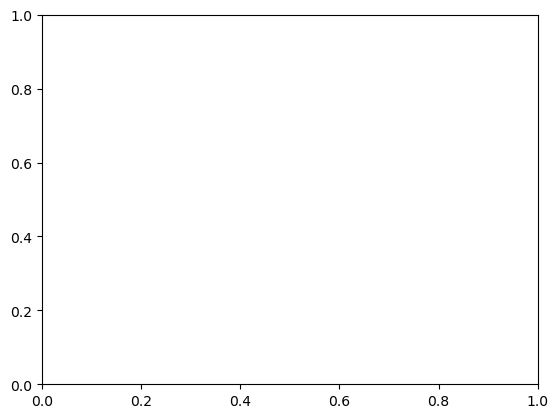

In [30]:
Xpred = X
#Xpred['Paso']=0
#Xpred['mPaso']=0
Xpred['Etapa1_2']=0
Xpred['Invierno']=0
Xpred['Otoño']=0
Xpred['ContactosEstrechos']=0
Xpred['Defunciones']=0
yhat = cre.predict(Xpred)

sns.histplot(data=y, color="skyblue", label="log-MP (observed)", kde=True)
sns.histplot(data=yhat, color="red", label="unobserved heterogeneity", kde=True)

plt.legend() 
plt.show()

### 8. Usando sus respuestas anteriores, que modelo prefiere? que se puede inferir en general respecto del efecto de las variables explicativas sobre el numero de trabajadores?

En vista de las comparaciones anteriores, tendría sentido escoger el modelo CRE pro sobre los otros.

In [ ]:
print(lmp.compare({"FE": fe, "RE": re, "CRE": cre}))

                             Model Comparison                            
                                   FE                RE               CRE
-------------------------------------------------------------------------
Dep. Variable                      MP                MP                MP
Estimator                    PanelOLS     RandomEffects     RandomEffects
No. Observations                  348               348               348
Cov. Est.                      Robust            Robust            Robust
R-squared                      0.4636            0.4312            0.4548
R-Squared (Within)             0.4636            0.4567            0.4636
R-Squared (Between)           -0.7668            0.0236            0.3021
R-Squared (Overall)            0.1924            0.3613            0.4280
F-statistic                    54.277            51.852            40.515
P-value (F-stat)               0.0000            0.0000            0.0000
=====================     =========== 

### 9. Es posible que sus resultados anteriores tengan sesgo dado que las cuarentenas (paso a paso) son endogenas al comportamiento de las personas. Construya AL MENOS DOS instrumentos posibles para las cuarentenas dinamicas, de forma que se pueda corregir el sesgo y entender el efecto causal de las cuarentenas en el aire. Realice su estimacion considerando un modelo agrupado (ignorando el tiempo), y el modelo de panel.

In [ ]:
def calcular_promedios_mensuales(carpeta):
    archivos = [f for f in os.listdir(carpeta) if f.endswith('.csv')];
    datos = [];

    for archivo in archivos:
        ruta = os.path.join(carpeta, archivo);
        df_temp = pd.read_csv(ruta);
        try:
            df_temp['fecha'] = pd.to_datetime(archivo.split('-')[0] + '-' + archivo.split('-')[1] + '-2021', format='%d-%m-%Y');
        except ValueError:
            df_temp['fecha'] = pd.to_datetime('2021-' + archivo.split('-')[1] + '-' + archivo.split('-')[2].split('.')[0], format='%Y-%m-%d');
        df_temp = df_temp[['Codigo comuna', 'Poblacion', 'Casos Confirmados', 'fecha']];
        df_temp['Mes'] = df_temp['fecha'].dt.month;
        datos.append(df_temp);
    df_concatenado = pd.concat(datos);
    df_mensual = df_concatenado.groupby(['Codigo comuna', 'Mes']).agg({
        'Casos Confirmados': 'sum',
        'Poblacion': 'first'
    }).reset_index();

    df_mensual['CasosConfirmados'] = df_mensual['Casos Confirmados'] / df_mensual['Poblacion'];

    return df_mensual;

carpeta = 'Producto 2';
promedios_mensuales = calcular_promedios_mensuales(carpeta);
df['codigo_comuna'] = df['codigo_comuna'].astype(int);

df = df.reset_index();
df = pd.merge(df, promedios_mensuales, left_on=['codigo_comuna', 'Mes'], right_on=['Codigo comuna', 'Mes'], how='left');
df = df.drop(columns=['Codigo comuna']);

df['CasosRezagados'] = df.groupby('Comuna')['CasosConfirmados'].shift(1);

df.set_index(['Comuna', 'Mes'], inplace=True);
df.sort_index(level=['Comuna', 'Mes'], inplace=True);

df.head(15)

NameError: name 'os' is not defined

In [ ]:
df = df.dropna(subset=['CasosRezagados']);
df["MP"] = df["MP"].astype(float);
iv_model = IV2SLS(df['MP'], sm.add_constant(df[['ContactosEstrechos', 'Defunciones', 'Invierno', 'Otoño']]), 
                           df[['Etapa1_2']], df[['CasosRezagados']]);
iv_results = iv_model.fit(cov_type='unadjusted')
print("Modelo Agrupado")
print(iv_results.summary)

NameError: name 'df' is not defined